Business Problem:
FinSecure is a peer-to-peer lending platform that must accurately assess the risk of a borrower defaulting on a loan. Incorrect decisions cause financial loss to investors and reduce trust in the platform. Therefore, the company wants a data-driven model to predict whether a loan will be paid back in full.

Objective:
To build a machine learning model that predicts the probability that a loan will be paid back (loan_paid_back = 1), which indirectly helps identify borrowers who are likely to default (loan_paid_back = 0).

What is Default?
In this dataset:
A default occurs when loan_paid_back = 0.
A successful repayment occurs when loan_paid_back = 1.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report


In [41]:
df = pd.read_csv("loan_data.csv")
df.info()
print("Shape of data:", df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268114 entries, 0 to 268113
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    268114 non-null  int64  
 1   annual_income         268114 non-null  float64
 2   debt_to_income_ratio  268114 non-null  float64
 3   credit_score          268114 non-null  int64  
 4   loan_amount           268114 non-null  float64
 5   interest_rate         268114 non-null  float64
 6   gender                268114 non-null  object 
 7   marital_status        268114 non-null  object 
 8   education_level       268114 non-null  object 
 9   employment_status     268114 non-null  object 
 10  loan_purpose          268114 non-null  object 
 11  grade_subgrade        268114 non-null  object 
 12  loan_paid_back        268114 non-null  int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 26.6+ MB
Shape of data: (268114, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [3]:
# Check target distribution
target_counts = df['loan_paid_back'].value_counts()
target_ratio = df['loan_paid_back'].value_counts(normalize=True)

In [4]:
print("Counts:\n", target_counts)
print("\nProportions:\n", target_ratio)


Counts:
 loan_paid_back
1    214068
0     54046
Name: count, dtype: int64

Proportions:
 loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64


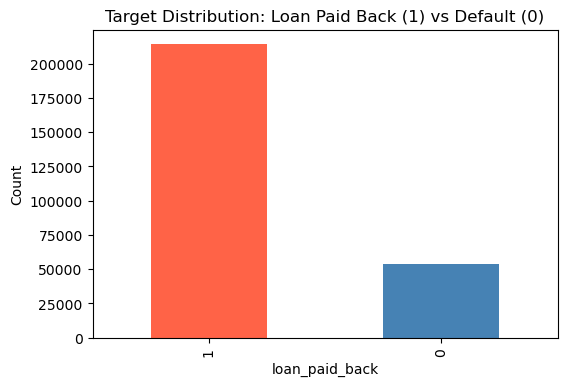

loan_paid_back
1    0.798422
0    0.201578
Name: proportion, dtype: float64


In [9]:
plt.figure(figsize=(6,4))
df['loan_paid_back'].value_counts().plot(kind='bar', color=['tomato', 'steelblue'])
plt.title("Target Distribution: Loan Paid Back (1) vs Default (0)")
plt.xlabel("loan_paid_back")
plt.ylabel("Count")
plt.show()

print(df['loan_paid_back'].value_counts(normalize=True))


### EDA

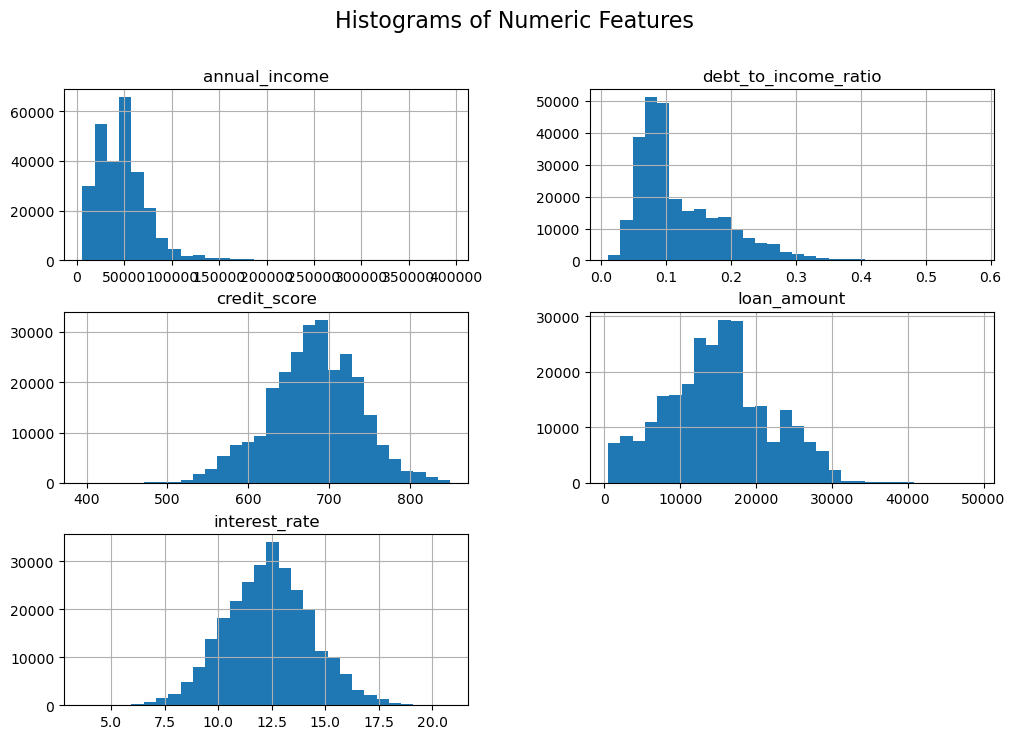

In [11]:
numeric_cols = [
    'annual_income', 'debt_to_income_ratio', 'credit_score',
    'loan_amount', 'interest_rate'
]

df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()


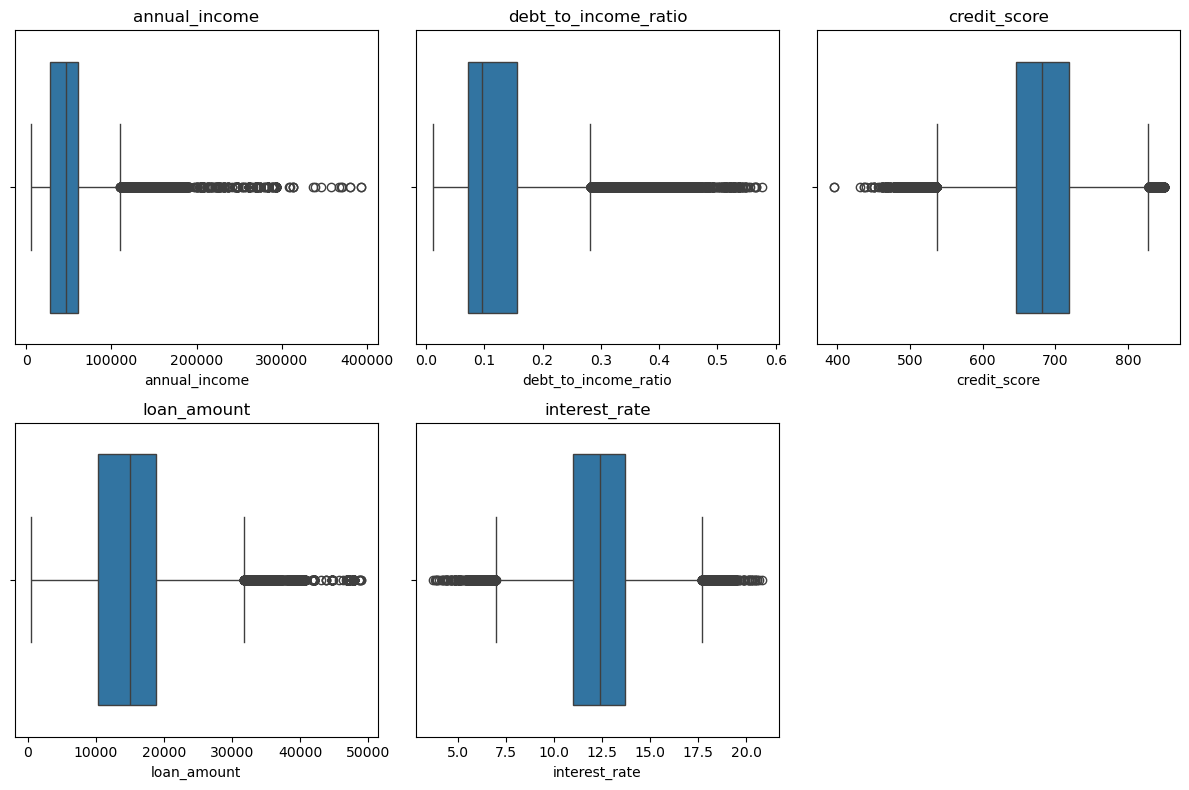

In [12]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


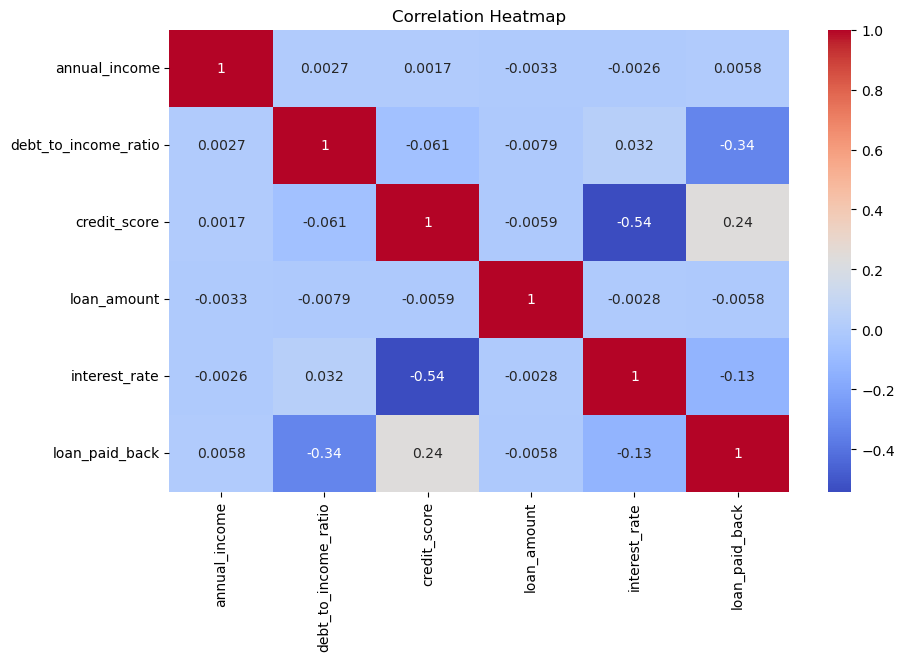

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols + ['loan_paid_back']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### TRAIN–TEST SPLIT

In [14]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['loan_paid_back']
)

X_train = train_df.drop(columns=['id', 'loan_paid_back'])
y_train = train_df['loan_paid_back']

X_test = test_df.drop(columns=['id', 'loan_paid_back'])
y_test = test_df['loan_paid_back']


In [16]:
X_train

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
228143,51345.02,0.182,711,2415.41,11.43,Male,Married,High School,Employed,Debt consolidation,C2
214995,92640.92,0.263,645,17710.85,12.52,Male,Single,Bachelor's,Unemployed,Debt consolidation,D1
165554,67553.59,0.120,615,9441.04,11.73,Female,Single,High School,Employed,Debt consolidation,D4
146752,48352.30,0.171,673,10673.15,12.83,Male,Single,Bachelor's,Employed,Other,C4
55579,58941.17,0.107,753,12772.36,10.04,Female,Married,Master's,Employed,Debt consolidation,B1
...,...,...,...,...,...,...,...,...,...,...,...
146938,64180.69,0.169,724,22647.69,10.26,Male,Single,Bachelor's,Employed,Education,C1
113875,62405.97,0.095,624,2521.62,14.99,Female,Married,Bachelor's,Employed,Car,D2
112532,30248.52,0.095,662,17296.56,9.85,Female,Single,High School,Employed,Other,D4
171094,29364.32,0.058,682,9672.09,12.68,Male,Married,Bachelor's,Employed,Debt consolidation,C4


# PREPROCESSING


### Identify numeric & categorical column

In [18]:
numeric_features = numeric_cols

categorical_features = [
    'gender', 'marital_status', 'education_level',
    'employment_status', 'loan_purpose', 'grade_subgrade'
]


### Build transformer

In [23]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)])


Chosen Model
I have used Logistic Regression because:It handles imbalanced classes using class weights
Works well with a mix of numeric and categorical features,
Produces interpretable results,
Trains quickly and performs well with well-processed data
Training Approach
Built a pipeline with (preprocessor + model)
Used GridSearchCV with ROC-AUC as the scoring metric
Tuned hyperparameters like:
penalty (L1/L2)
C (regularization strength)
Evaluation Metric: ROC-AUC
We used ROC-AUC because:
Dataset is imbalanced
AUC measures the model’s ability to rank default vs non-default correctly
Threshold-independent metric
Performance We computed:
AUC on test set
ROC curve
Confusion matrix
Classification report
A high AUC (>0.75) indicates the model separates good.

### Logistic Regression

In [25]:
log_reg = LogisticRegression( random_state=42,max_iter=500,# increase iterations to ensure convergence
    class_weight="balanced",   # handle imbalance
    solver="liblinear"    # good for small datasets & L1/L2 penalty
)

clf = Pipeline(steps=[("preprocessor", preprocessor),("model", log_reg)])


In [27]:
## Hyperparameter Tuning
param_grid = {"model__penalty": ["l1", "l2"],
    "model__C": [0.1, 1, 10, 50, 100]}


In [29]:
### Grid Search with ROC-AUC
grid = GridSearchCV(clf,param_grid,cv=3,scoring="roc_auc",n_jobs=-1,verbose=2)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__C': 0.1, 'model__penalty': 'l1'}
Best CV AUC: 0.9095714274332357


In [30]:
best_model = grid.best_estimator_

y_proba = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)

print("Test AUC:", test_auc)


Test AUC: 0.9122156144108313


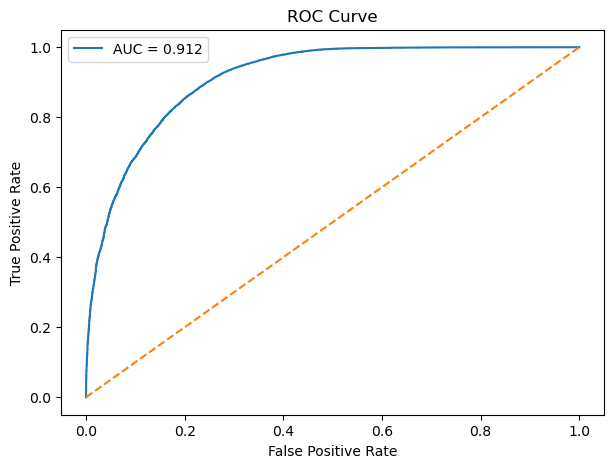

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [32]:
y_pred = (y_proba >= 0.5).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.77      0.69     10809
           1       0.94      0.88      0.91     42814

    accuracy                           0.86     53623
   macro avg       0.78      0.83      0.80     53623
weighted avg       0.88      0.86      0.87     53623



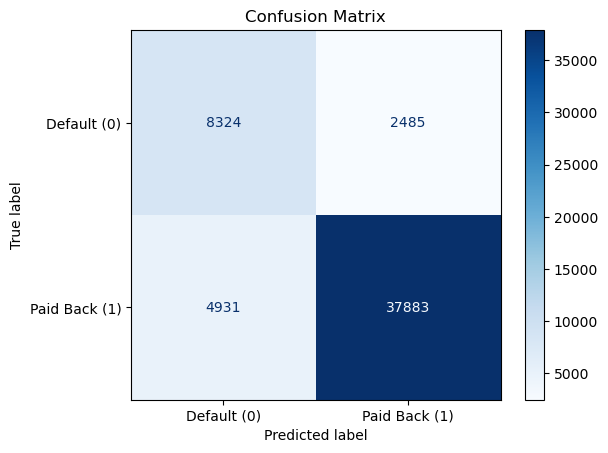

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default (0)", "Paid Back (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [35]:
## predictions
test_analysis = test_df.copy()
test_analysis["y_true"] = y_test.values
test_analysis["y_proba"] = y_proba


In [36]:
## AUC function
def subgroup_auc(df, group_col):
    results = []
    for val, group in df.groupby(group_col):
        if group['y_true'].nunique() < 2:
            continue  # AUC needs both classes
        auc = roc_auc_score(group['y_true'], group['y_proba'])
        results.append({"group": val, "auc": auc, "n": len(group)})

    return pd.DataFrame(results).sort_values("auc", ascending=False)


In [37]:
## AUC by Education Level
edu_auc = subgroup_auc(test_analysis, "education_level")
print("AUC by Education Level:\n")
print(edu_auc)


AUC by Education Level:

         group       auc      n
3        Other  0.925103   2336
0   Bachelor's  0.912843  25263
1  High School  0.910725  16701
4          PhD  0.909063    982
2     Master's  0.908928   8341


In [39]:
### AUC by Loan Purpose (Top 3 & Bottom 3)
purpose_auc = subgroup_auc(test_analysis, "loan_purpose")

print("Top 3 Loan Purposes:\n")
print(purpose_auc.head(3))

print("\nBottom 3 Loan Purposes:\n")
print(purpose_auc.tail(3))


Top 3 Loan Purposes:

       group       auc     n
3  Education  0.923768  3202
7   Vacation  0.920240   760
5    Medical  0.919050  2088

Bottom 3 Loan Purposes:

                group       auc      n
0            Business  0.912085   3091
2  Debt consolidation  0.911635  29317
1                 Car  0.901296   5353
